In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
train=pd.read_csv(r'Data_Sets\train.csv')
test=pd.read_csv(r'Data_Sets\test.csv')

In [6]:
train.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


In [7]:
test.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3


In [8]:
# Adding a column to know which row belong to which dataset
train['source']='train'
test['source']='test'



In [9]:
train.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,source
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,train
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,train
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268,train
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376,train
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829,train


In [10]:
test.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,source
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3,test
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3,test
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1,test
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2,test
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3,test


In [11]:
target=train['Sales']

In [12]:
train.drop(['Sales'],axis=1,inplace=True)

In [13]:
train.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,source
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,train
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,train
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,train
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,train
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,train


In [14]:
combined=pd.concat([train,test],ignore_index=True)

In [15]:
combined.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,source
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,train
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,train
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,train
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,train
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,train


In [16]:
combined.isna().sum()

Item_ID                 0
Item_W                  0
Item_Type               0
Item_MRP                0
Outlet_ID               0
Outlet_Year             0
Outlet_Size             0
Outlet_Location_Type    0
source                  0
dtype: int64

In [17]:
combined.duplicated().sum()

np.int64(0)

In [18]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125520 entries, 0 to 125519
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Item_ID               125520 non-null  object 
 1   Item_W                125520 non-null  float64
 2   Item_Type             125520 non-null  object 
 3   Item_MRP              125520 non-null  float64
 4   Outlet_ID             125520 non-null  object 
 5   Outlet_Year           125520 non-null  int64  
 6   Outlet_Size           125520 non-null  object 
 7   Outlet_Location_Type  125520 non-null  object 
 8   source                125520 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 8.6+ MB


In [19]:
train_cleaned = combined[combined['source'] == 'train'].copy()
test_cleaned = combined[combined['source'] == 'test'].copy()


In [20]:
train_cleaned['Sales']=target

In [21]:
print(train_cleaned.shape)
print(test_cleaned.shape)

print(train_cleaned.columns)
print(test_cleaned.columns)


(87864, 10)
(37656, 9)
Index(['Item_ID', 'Item_W', 'Item_Type', 'Item_MRP', 'Outlet_ID',
       'Outlet_Year', 'Outlet_Size', 'Outlet_Location_Type', 'source',
       'Sales'],
      dtype='object')
Index(['Item_ID', 'Item_W', 'Item_Type', 'Item_MRP', 'Outlet_ID',
       'Outlet_Year', 'Outlet_Size', 'Outlet_Location_Type', 'source'],
      dtype='object')


In [22]:
train_cleaned.drop(columns=['source'],inplace=True)
test_cleaned.drop(columns=['source'],inplace=True)

In [23]:
train_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


In [24]:
test_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
87864,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
87865,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
87866,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1
87867,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2
87868,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3


## EDA

##### Univariate Analysis

In [25]:
num_cols=train_cleaned.select_dtypes(include=['number','int','float'])
cat_cols=train_cleaned.select_dtypes(exclude=['number','int','float'])

In [26]:
num_cols.columns

Index(['Item_W', 'Item_MRP', 'Outlet_Year', 'Sales'], dtype='object')

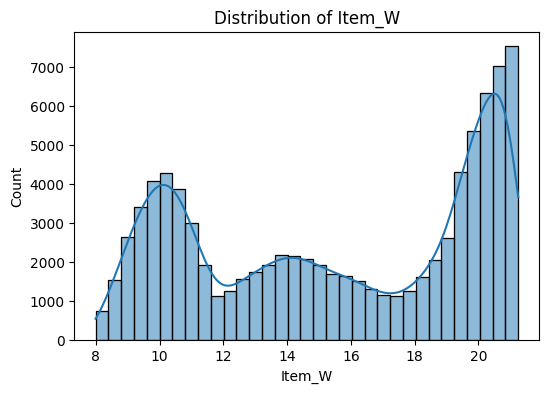

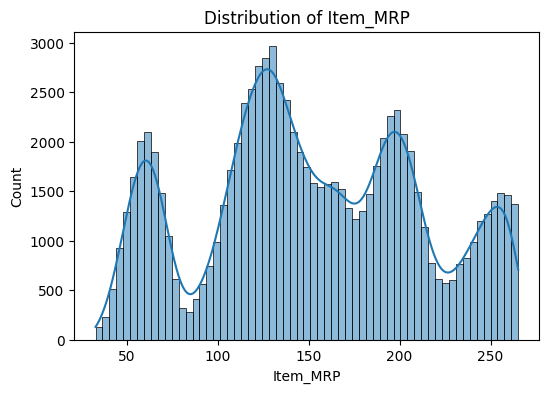

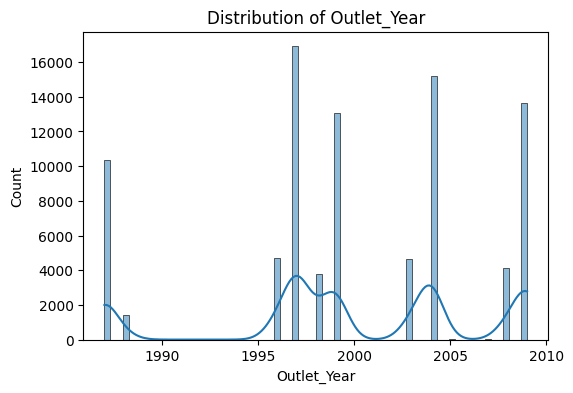

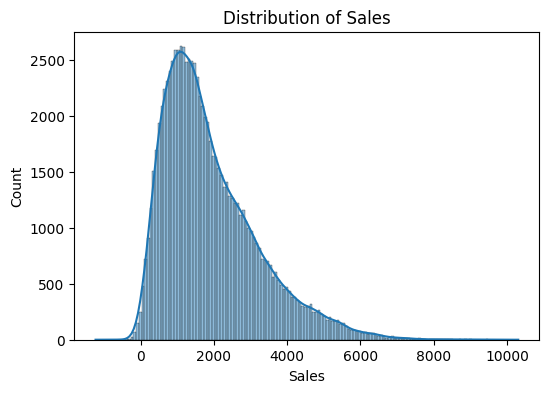

In [27]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(train_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [28]:
from scipy.stats import skew
print("Skewness:", skew(num_cols['Sales']))

Skewness: 1.1254297417477983


In [29]:
num_cols['Sales'].describe()

count    87864.000000
mean      1911.842120
std       1291.386004
min      -1229.360345
25%        959.249675
50%       1606.307877
75%       2608.057736
max      10309.283310
Name: Sales, dtype: float64

In [30]:
# Skewness 1.125 means that the target column is right skewed, hence we use log transformation to make it normal

In [31]:
train_cleaned['Sales_transformed'] = np.log1p(num_cols['Sales'])

c:\Data Science\Machine_learning\Regression\Supermarket_Data\env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


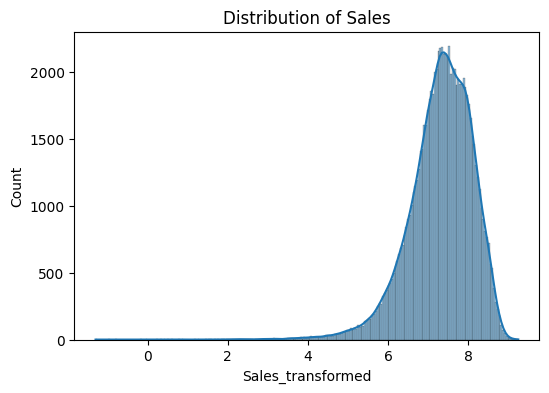

In [32]:
plt.figure(figsize=(6,4))
sns.histplot(train_cleaned['Sales_transformed'], kde=True)
plt.title(f'Distribution of {col}')
plt.show()

In [33]:
from scipy.stats import skew
print(skew(train_cleaned['Sales_transformed']))

nan


In [34]:
# num_cols['Sales_transformed'].describe()


In [35]:
# using powertransformer to handle skeweness

In [36]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
train_cleaned['Sales_transformed'] = pt.fit_transform(num_cols[['Sales']])


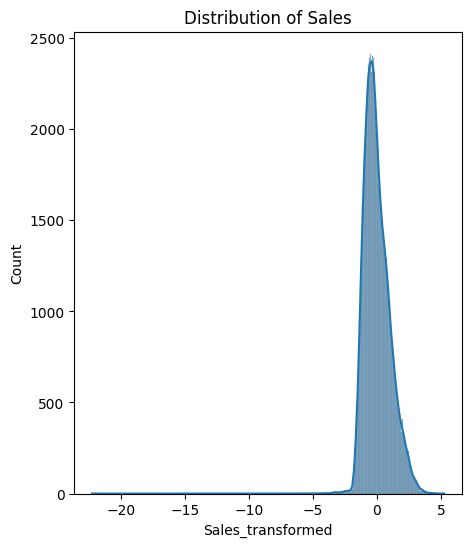

In [37]:
plt.figure(figsize=(5,6))
sns.histplot(train_cleaned['Sales_transformed'], kde=True)
plt.title(f'Distribution of {col}')
plt.show()

In [38]:
print(skew(train_cleaned['Sales_transformed']))

0.4104238937430579


In [39]:
num_cols=train_cleaned.select_dtypes(include=['int','float','number'])

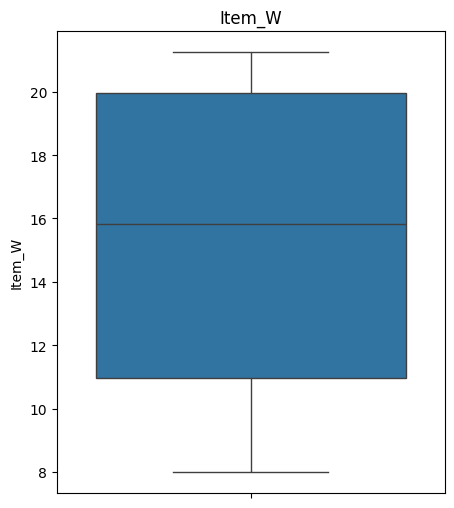

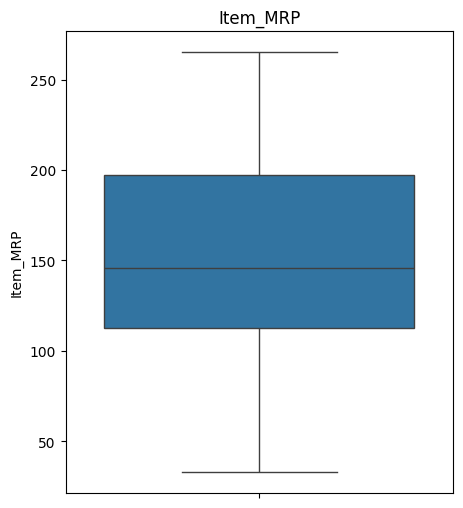

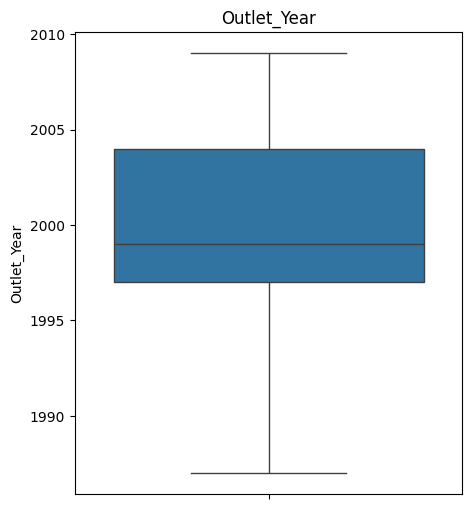

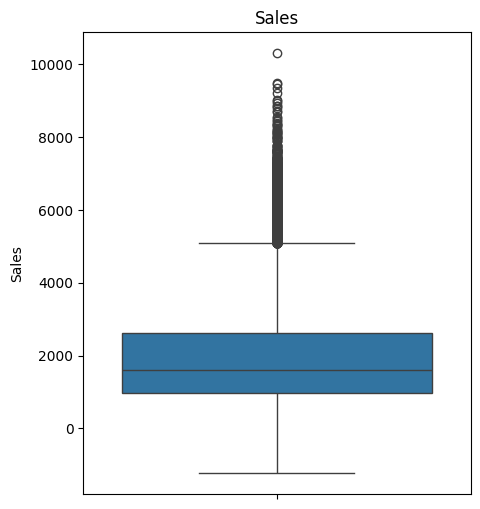

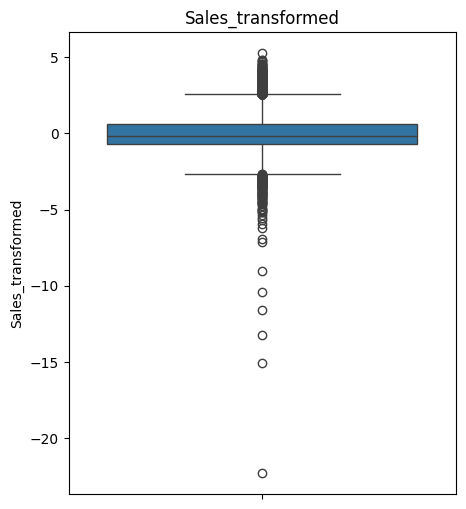

In [40]:
for col in num_cols:
    plt.figure(figsize=(5,6))
    sns.boxplot(num_cols[col])
    plt.title(col)
    plt.show()

In [ ]:
# We can see that there are outliers present in the target column

In [42]:
import numpy as np

Q1 = num_cols['Sales_transformed'].quantile(0.25)
Q3 = num_cols['Sales_transformed'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = num_cols[(num_cols['Sales_transformed'] < lower_bound) | (num_cols['Sales_transformed'] > upper_bound)]
print(f"Outlier count: {len(outliers)} ({len(outliers)/len(num_cols)*100:.2f}% of data)")


Outlier count: 1377 (1.57% of data)


In [43]:
# To deal with outlier we use Winsorization

# Winsorization is a statistical technique used to limit the influence of extreme values (outliers)
#  by capping them at specific percentile thresholds — rather than removing them.
# It brings extreme values closer to the bulk of the data, instead of deleting them.


In [44]:
train_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,Sales_transformed
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,0.659990
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,1.185292
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268,0.972822
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376,-0.413453
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829,-0.057946


In [ ]:
from scipy.stats.mstats import winsorize
train_cleaned['Sales_transformed_capped']=winsorize(train_cleaned['Sales_transformed'],limits=[0.01,0.01])


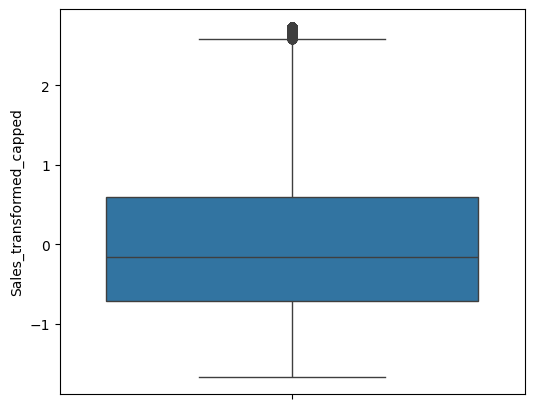

In [48]:
plt.figure(figsize=(6,5))
sns.boxplot(train_cleaned['Sales_transformed_capped'])
plt.show()

In [50]:
cat_cols.head()

,Item_ID,Item_Type,Outlet_ID,Outlet_Size,Outlet_Location_Type
0,FDU32,Baking Goods,OUT046,Small,Tier 2
1,NCT54,Meat,OUT035,Small,Tier 1
2,FDW08,Hard Drinks,OUT035,Small,Tier 3
3,FDJ22,Starchy Foods,OUT046,Small,Tier 1
4,FDF47,Baking Goods,OUT035,Small,Tier 3


In [ ]:
for col in cat_cols:
    vc = train_cleaned[col].value_counts() # counts how many times each unique category appears in that column.
    pct = train_cleaned[col].value_counts(normalize=True).mul(100)#finds what percentage of total data each represents.
    summary = pd.concat([vc, pct], axis=1)
    summary.columns = ['count','percent']
    print(f"\n=== {col} ===")
    print(summary)



=== Item_ID ===
         count   percent
Item_ID                 
FDE11      419  0.004769
NCE07      362  0.004120
NCL18      346  0.003938
NCO06      336  0.003824
FDD51      329  0.003744
...        ...       ...
DRF60        2  0.000023
FDC32        2  0.000023
FDI12        2  0.000023
FDA22        1  0.000011
NCM19        1  0.000011

[895 rows x 2 columns]

=== Item_Type ===
                       count   percent
Item_Type                             
Baking Goods           14666  0.166917
Fruits and Vegetables  14328  0.163070
Meat                    8099  0.092177
Snack Foods             7817  0.088967
Household               6018  0.068492
Soft Drinks             5396  0.061413
Frozen Foods            5129  0.058374
Canned                  4565  0.051955
Dairy                   3807  0.043328
Others                  3688  0.041974
Breads                  3509  0.039937
Hard Drinks             3129  0.035612
Health and Hygiene      2995  0.034087
Starchy Foods           2974  